In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rc('legend',fontsize=16)
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 14, 'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14})
sns.set_style("whitegrid", rc={'font.size': 16})

from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from constants import LOCATION_CHOOSEN, INPUT_DIR, OUTPUT_DIR, DATA_CACHE_DIR, STRINGENCY_BASED_GDP

data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + ".csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_csv(os.path.join(INPUT_DIR, "owid-covid-data.csv"))
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

print(f'All columns in dataset: {df.columns}')

All columns in dataset: Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinati

In [2]:
df = df[["date", "stringency_index", "total_cases", "total_deaths", "total_vaccinations", "population", "people_fully_vaccinated"]]

def print_missing_stats(df, title):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    print(f'{title}: \n{missing_value_df}')


print_missing_stats(df, "Before preprocessing")

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.interpolate(method='time', inplace=True)

print_missing_stats(df, "After interpolation")

df.ffill(inplace=True)
df.bfill(inplace=True)

print_missing_stats(df, "After complete preprocessing")

Before preprocessing: 
                                     column_name  percent_missing
date                                        date         0.000000
population                            population         0.000000
total_cases                          total_cases         1.865930
total_deaths                        total_deaths         4.837595
stringency_index                stringency_index        24.395301
total_vaccinations            total_vaccinations        27.988943
people_fully_vaccinated  people_fully_vaccinated        30.131306
After interpolation: 
                                     column_name  percent_missing
stringency_index                stringency_index         0.000000
population                            population         0.000000
total_cases                          total_cases         1.865930
total_deaths                        total_deaths         4.837595
total_vaccinations            total_vaccinations        26.123013
people_fully_vaccinated  people

In [3]:
df

,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated
date,,,,,,
2020-01-03,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-04,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-05,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-06,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-07,0.0,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
...,...,...,...,...,...,...
2023-12-15,28.7,45004142.0,533310.0,2.206751e+09,1.417173e+09,951987170.0
2023-12-16,28.7,45004481.0,533311.0,2.206751e+09,1.417173e+09,951987190.0
2023-12-17,28.7,45004816.0,533316.0,2.206752e+09,1.417173e+09,951987225.0


0.0


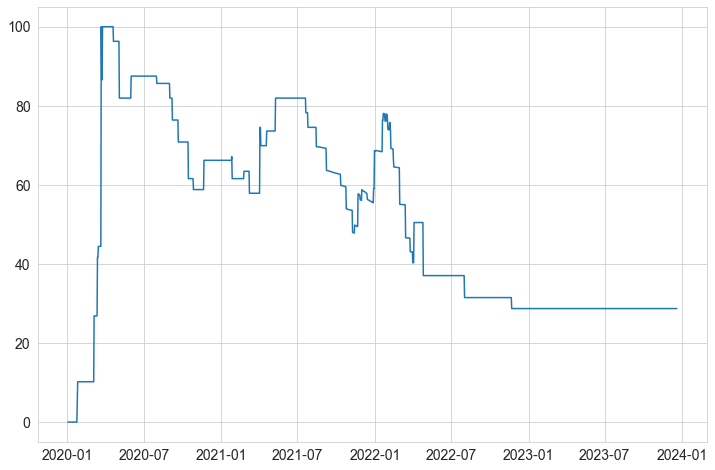

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(df['stringency_index'])
print(min(df['stringency_index']))

In [5]:
# df = df[(df.index >= '2020-03-01 00:00:00') & (df.index <= '2023-11-01 00:00:00')]
# df = df[(df.index >= '2020-05-1 00:00:00') & (df.index <= '2022-11-01 00:00:00')]
df = df[(df.index <= '2022-11-01 00:00:00')]
df

,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated
date,,,,,,
2020-01-03,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-04,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-05,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-06,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-07,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
...,...,...,...,...,...,...
2022-10-28,31.48,44649088.0,528999.0,2.196044e+09,1.417173e+09,950032740.0
2022-10-29,31.48,44650662.0,529008.0,2.196215e+09,1.417173e+09,950066782.0
2022-10-30,31.48,44652266.0,529016.0,2.196336e+09,1.417173e+09,950090439.0


0.0


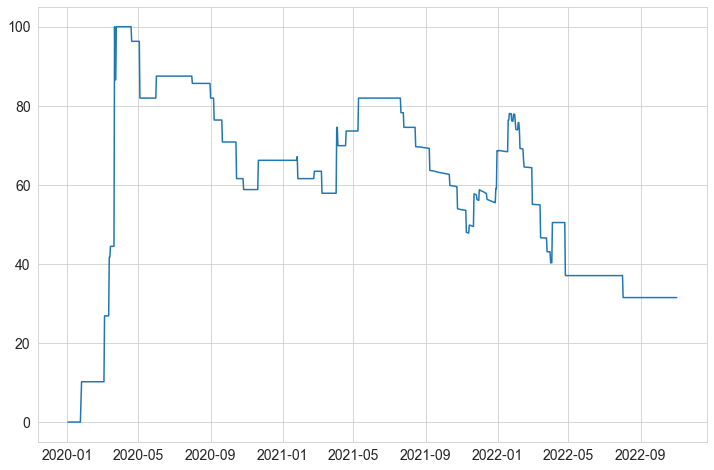

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(df['stringency_index'])
print(min(df['stringency_index']))

In [7]:
mei_data = pd.read_csv(os.path.join(INPUT_DIR, "MEI_28122023111527409.csv"))
print(f'MEI data columns: {mei_data.columns}')
print(f'MEI data subjects: {mei_data["Subject"].unique()}')
print(f'MEI data locations: {mei_data["LOCATION"].unique()}')

MEI data columns: Index(['LOCATION', 'Country', 'SUBJECT', 'Subject', 'MEASURE', 'Measure',
       'FREQUENCY', 'Frequency', 'TIME', 'Time', 'Unit Code', 'Unit',
       'PowerCode Code', 'PowerCode', 'Reference Period Code',
       'Reference Period', 'Value', 'Flag Codes', 'Flags'],
      dtype='object')
MEI data subjects: ['Leading Indicators OECD > Component series > Bank activity > Normalised'
 'Leading Indicators OECD > Component series > Bank activity > Original series'
 'Leading Indicators OECD > Component series > BTS - Sales expectations > Normalised'
 'Leading Indicators OECD > Component series > BTS - Sales expectations > Original series'
 'Leading Indicators OECD > Component series > BTS - Demand or orders inflow > Normalised'
 'Leading Indicators OECD > Component series > BTS - Demand or orders inflow > Original series'
 'Leading Indicators OECD > Component series > BTS - Employment > Normalised'
 'Leading Indicators OECD > Component series > BTS - Employment > Original se

/tmp/ipykernel_48084/2507240915.py:1: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  mei_data = pd.read_csv(os.path.join(INPUT_DIR, "MEI_28122023111527409.csv"))


In [8]:
df

,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated
date,,,,,,
2020-01-03,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-04,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-05,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-06,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
2020-01-07,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0
...,...,...,...,...,...,...
2022-10-28,31.48,44649088.0,528999.0,2.196044e+09,1.417173e+09,950032740.0
2022-10-29,31.48,44650662.0,529008.0,2.196215e+09,1.417173e+09,950066782.0
2022-10-30,31.48,44652266.0,529016.0,2.196336e+09,1.417173e+09,950090439.0


In [9]:
# print(mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Original Series")].columns)
print(mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised")].columns)

Index(['LOCATION', 'Country', 'SUBJECT', 'Subject', 'MEASURE', 'Measure',
       'FREQUENCY', 'Frequency', 'TIME', 'Time', 'Unit Code', 'Unit',
       'PowerCode Code', 'PowerCode', 'Reference Period Code',
       'Reference Period', 'Value', 'Flag Codes', 'Flags'],
      dtype='object')


In [10]:
print(mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised")][["TIME", "Value", "SUBJECT"]])

          TIME       Value   SUBJECT
24060  2016-01  100.250840  LORSGPNO
24061  2016-02  100.357363  LORSGPNO
24062  2016-03  100.456021  LORSGPNO
24063  2016-04  100.544158  LORSGPNO
24064  2016-05  100.619914  LORSGPNO
...        ...         ...       ...
24147  2023-04  100.759382  LORSGPNO
24148  2023-05  100.945977  LORSGPNO
24149  2023-06  101.134992  LORSGPNO
24150  2023-07  101.325693  LORSGPNO
24151  2023-08  101.517631  LORSGPNO

[92 rows x 3 columns]


In [11]:
print(mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised")]["SUBJECT"].unique())

['LORSGPNO']


In [12]:
def merge_data(df, mei_data, subject_selected):
    df_gdp = mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == subject_selected) & (mei_data["SUBJECT"] == "LORSGPNO")]
    print(subject_selected, df_gdp.shape[0])
    """
    if subject_based_data.shape[0] > 0:
        subject_based_data.loc[:, 'TIME'] = pd.to_datetime(subject_based_data['TIME'])
        print(subject_based_data['TIME'].unique())
        merged_df = pd.merge(df, subject_based_data[['TIME', 'Value']], left_on='date', right_on='TIME', how='inner')
        merged_df.drop(columns=['TIME'], inplace=True)
        merged_df.rename(columns={'Value': "".join(subject_selected.split(">")[2:])}, inplace=True)
        df = merged_df
        return df
    """
    if df_gdp.shape[0] > 0:
        df_gdp.rename(columns={'TIME': 'date'}, inplace=True)
        df_gdp['date'] = pd.to_datetime(df_gdp['date'])
        df_gdp = df_gdp[['date', 'Value']]
        df_gdp.rename(columns={'Value': "gdp_normalized"}, inplace=True)
        print_missing_stats(df_gdp, "Before preprocessing")
        
        df_gdp.set_index('date', inplace=True)

        # Merge the two DataFrames
        df_merged = pd.concat([df, df_gdp], axis=1)
        
        # df_merged.interpolate(method='time', inplace=True)
        
        print("Min-max date before: ", df_merged.index.min(), df_merged.index.max())
        min_date = df.index.min()
        max_date = df.index.max()
        df_merged = df_merged[(df_merged.index >= min_date) & (df_merged.index <= max_date)]
        print("Min-max date before: ", df_merged.index.min(), df_merged.index.max())
        return df_merged

In [13]:
df_merged = merge_data(df, mei_data, "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised")
df_merged

Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised 92
Before preprocessing: 
                   column_name  percent_missing
date                      date              0.0
gdp_normalized  gdp_normalized              0.0
Min-max date before:  2016-01-01 00:00:00 2023-08-01 00:00:00
Min-max date before:  2020-01-03 00:00:00 2022-11-01 00:00:00


/tmp/ipykernel_48084/1800667369.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp.rename(columns={'TIME': 'date'}, inplace=True)
/tmp/ipykernel_48084/1800667369.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp['date'] = pd.to_datetime(df_gdp['date'])


,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized
date,,,,,,,
2020-01-03,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-04,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-05,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-06,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
2020-01-07,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN
...,...,...,...,...,...,...,...
2022-10-28,31.48,44649088.0,528999.0,2.196044e+09,1.417173e+09,950032740.0,NaN
2022-10-29,31.48,44650662.0,529008.0,2.196215e+09,1.417173e+09,950066782.0,NaN
2022-10-30,31.48,44652266.0,529016.0,2.196336e+09,1.417173e+09,950090439.0,NaN


In [14]:
df = df_merged
print(df.columns)

Index(['stringency_index', 'total_cases', 'total_deaths', 'total_vaccinations',
       'population', 'people_fully_vaccinated', 'gdp_normalized'],
      dtype='object')


[-5.96640236e-05  6.65064332e-03 -2.23109924e-01  1.01357226e+02]
-5.966 x 10^-5
6.651 x 10^-3
-2.231 x 10^-1
1.014 x 10^2
GDP = $-5.966 \times 10^{{-5}} \times s^3 + 6.651 \times 10^{{-3}} \times s^2 + $
$-2.231 \times 10^{{-1}} \times s + 1.014 \times 10^{{2}}$
['GDP = $-5.966 \\times 10^{{-5}} \\times s^3 ', ' 6.651 \\times 10^{{-3}} \\times s^2 ', ' $\n$-2.231 \\times 10^{{-1}} \\times s ', ' 1.014 \\times 10^{{2}}$']


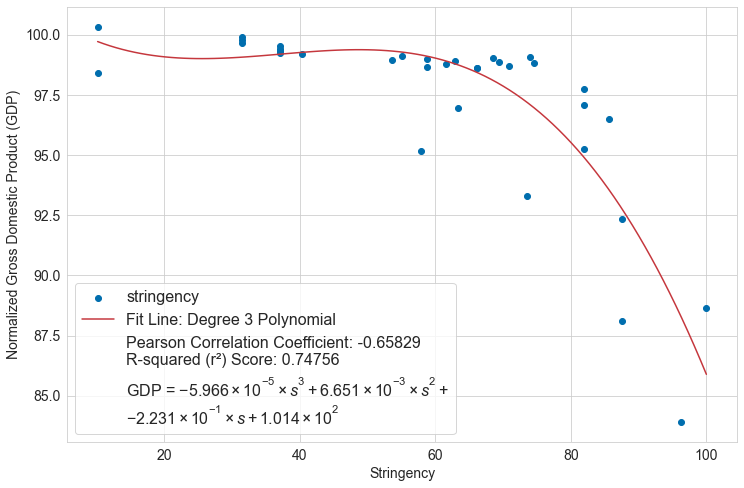

In [15]:
selected_dates = df[df['gdp_normalized'].notnull()].index
stringency = df.loc[selected_dates, 'stringency_index']
gdp = df.loc[selected_dates, 'gdp_normalized']

correlation_coefficient, _ = pearsonr(stringency, gdp)

fit_coefficients = np.polyfit(stringency, gdp, 3)
print(fit_coefficients)

def convert_to_power_notation(value):
    e_notation = f"{value:.3e}".split('e')
    base = float(e_notation[0])
    power = int(e_notation[1])
    print(rf"{base} x 10^{power}")
    return rf"{base} \times 10^{{{'{' + str(power) + '}'}}}"

# Apply the conversion to each coefficient and format the equation string
equation_string_part_1 = rf"GDP = ${convert_to_power_notation(fit_coefficients[0])} \times s^3 + " \
                  rf"{convert_to_power_notation(fit_coefficients[1])} \times s^2 + $"
equation_string_part_2 = rf"${convert_to_power_notation(fit_coefficients[2])} \times s + " \
                  rf"{convert_to_power_notation(fit_coefficients[3])}$"

equation_string = equation_string_part_1 + "\n" + equation_string_part_2
print(equation_string)
print(equation_string.split("+"))
fit_line = np.poly1d(fit_coefficients)

np.save('stringency_based_gdp.npy', fit_line)

r2 = r2_score(gdp, fit_line(stringency))

plt.figure(figsize=(12, 8))
plt.scatter(stringency, gdp, label="stringency", color="#006EAE")

stringency_range = np.linspace(min(stringency), max(stringency), 100)  # Generating a range for the fitted line
plt.plot(stringency_range, fit_line(stringency_range), label=f'Fit Line: Degree 3 Polynomial', color="#C5373D")
plt.plot([], [], ' ', label=f'Pearson Correlation Coefficient: {correlation_coefficient:.5f}\nR-squared (r²) Score: {r2:.5f}')
plt.plot([], [], ' ', label=equation_string)
# plt.figtext(0.64, 0.77, f'\nPearson Correlation Coefficient: {correlation_coefficient:.5f}\nR-squared (r²) Score: {r2:.5f}', fontsize=13)

# plt.title('Stringency vs. GDP for ' + LOCATION_CHOOSEN)
plt.xlabel('Stringency')
plt.ylabel('Normalized Gross Domestic Product (GDP)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "stringency_vs_gdp_" + LOCATION_CHOOSEN + ".pdf"), bbox_inches="tight")
plt.show()

In [16]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_with_GDP.csv"), index=False)

86.22728926295699 101.35722576976582


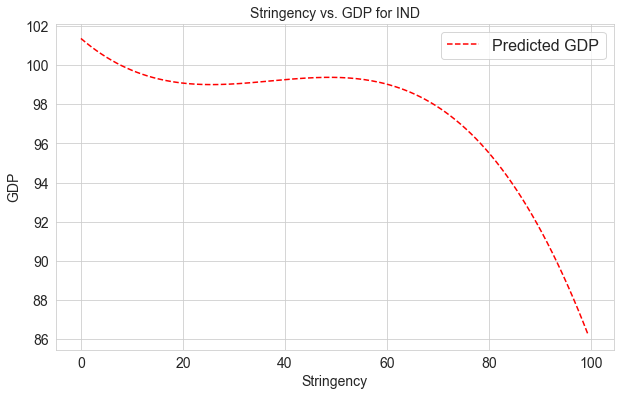

In [17]:
stringency_data_points = np.arange(0, 100, 0.5)
predicted_gdp = fit_line(stringency_data_points)

MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)
print(MIN_GDP, MAX_GDP)

plt.figure(figsize=(10, 6))
plt.plot(stringency_data_points, predicted_gdp, label="Predicted GDP", color='red', linestyle='--')
plt.title('Stringency vs. GDP for ' + LOCATION_CHOOSEN)
plt.xlabel('Stringency')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
# plt.savefig(os.path.join(OUTPUT_DIR, "stringency_vs_gdp_extended_" + LOCATION_CHOOSEN + ".pdf"))
plt.show()

In [18]:
# check save and load
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
print(fit_line_loaded(100.0))

85.88864296184516


In [19]:
df['gdp_normalized_modelled'] = fit_line_loaded(df['stringency_index'])

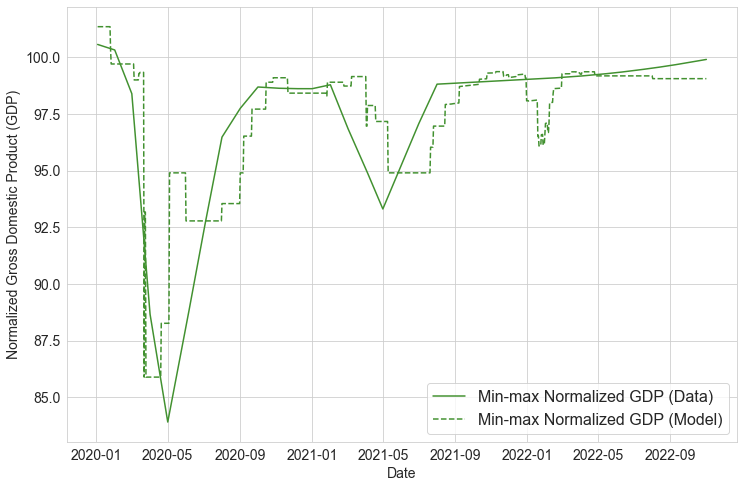

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(df['gdp_normalized'], color='#429130', label='Min-max Normalized GDP (Data)')
plt.plot(df['gdp_normalized_modelled'], color='#429130', label='Min-max Normalized GDP (Model)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Normalized Gross Domestic Product (GDP)')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "gdp_modelled_with_stringency_" + LOCATION_CHOOSEN + ".pdf"), bbox_inches="tight")
plt.show()

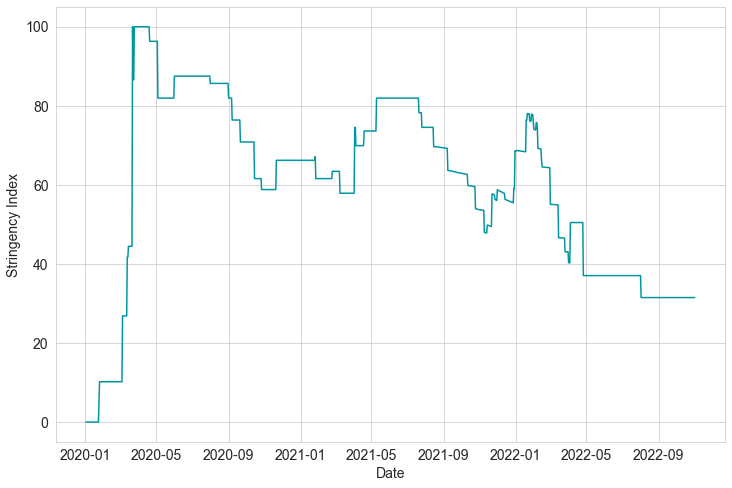

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(df['stringency_index'], color='#0096A0')
plt.xlabel('Date')
plt.ylabel('Stringency Index')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "stringency_index_" + LOCATION_CHOOSEN + ".pdf"), bbox_inches="tight")
plt.show()

In [22]:
print(selected_dates)

DatetimeIndex(['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01'],
              dtype='datetime64[ns]', name='date', freq=None)


In [23]:
initial_gdp = mei_data.loc[(mei_data['LOCATION'] == LOCATION_CHOOSEN) & (mei_data["Frequency"] == "Monthly") & (mei_data["Subject"] == "Leading Indicators OECD > Reference series > Gross Domestic Product (GDP) > Normalised") & (mei_data["TIME"] == '2020-01')][["TIME", "Value", "SUBJECT"]]
print(initial_gdp['Value'].item())

100.573650833479


In [24]:
display(df.loc[df.index == '2020-01-03 00:00:00', :])
df.loc[df.index == '2020-01-03 00:00:00', 'gdp_normalized'] = initial_gdp['Value'].item()
display(df)

,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized,gdp_normalized_modelled
date,,,,,,,,
2020-01-03,0.0,1.0,1.0,0.0,1.417173e+09,7668.0,NaN,101.357226


,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized,gdp_normalized_modelled
date,,,,,,,,
2020-01-03,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.573651,101.357226
2020-01-04,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN,101.357226
2020-01-05,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN,101.357226
2020-01-06,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN,101.357226
2020-01-07,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,NaN,101.357226
...,...,...,...,...,...,...,...,...
2022-10-28,31.48,44649088.0,528999.0,2.196044e+09,1.417173e+09,950032740.0,NaN,99.063148
2022-10-29,31.48,44650662.0,529008.0,2.196215e+09,1.417173e+09,950066782.0,NaN,99.063148
2022-10-30,31.48,44652266.0,529016.0,2.196336e+09,1.417173e+09,950090439.0,NaN,99.063148


In [25]:
print(min(df["stringency_index"]))

0.0


In [26]:
df.interpolate(method='time', inplace=True)
display(df)

,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized,gdp_normalized_modelled
date,,,,,,,,
2020-01-03,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.573651,101.357226
2020-01-04,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.565223,101.357226
2020-01-05,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.556796,101.357226
2020-01-06,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.548368,101.357226
2020-01-07,0.00,1.0,1.0,0.000000e+00,1.417173e+09,7668.0,100.539941,101.357226
...,...,...,...,...,...,...,...,...
2022-10-28,31.48,44649088.0,528999.0,2.196044e+09,1.417173e+09,950032740.0,99.893668,99.063148
2022-10-29,31.48,44650662.0,529008.0,2.196215e+09,1.417173e+09,950066782.0,99.898210,99.063148
2022-10-30,31.48,44652266.0,529016.0,2.196336e+09,1.417173e+09,950090439.0,99.902753,99.063148


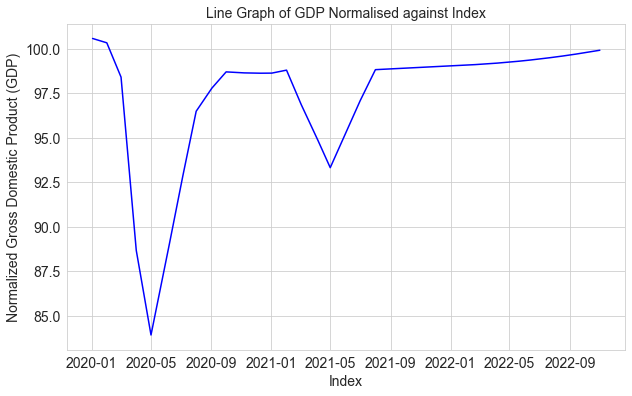

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df["gdp_normalized"], color='b')
plt.xlabel('Index')
plt.ylabel('Normalized Gross Domestic Product (GDP)')
plt.title('Line Graph of GDP Normalised against Index')
plt.show()

In [28]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))

In [29]:
print(LOCATION_CHOOSEN)

IND


In [30]:
shaved_df = df[(df.index >= '2020-05-1 00:00:00')]
shaved_df

,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized,gdp_normalized_modelled
date,,,,,,,,
2020-05-01,96.30,35043.0,1147.0,0.000000e+00,1.417173e+09,7668.0,83.905433,88.264410
2020-05-02,96.30,37336.0,1218.0,0.000000e+00,1.417173e+09,7668.0,84.041307,88.264410
2020-05-03,96.30,39980.0,1301.0,0.000000e+00,1.417173e+09,7668.0,84.177181,88.264410
2020-05-04,81.94,42533.0,1373.0,0.000000e+00,1.417173e+09,7668.0,84.313055,94.904432
2020-05-05,81.94,46433.0,1568.0,0.000000e+00,1.417173e+09,7668.0,84.448930,94.904432
...,...,...,...,...,...,...,...,...
2022-10-28,31.48,44649088.0,528999.0,2.196044e+09,1.417173e+09,950032740.0,99.893668,99.063148
2022-10-29,31.48,44650662.0,529008.0,2.196215e+09,1.417173e+09,950066782.0,99.898210,99.063148
2022-10-30,31.48,44652266.0,529016.0,2.196336e+09,1.417173e+09,950090439.0,99.902753,99.063148


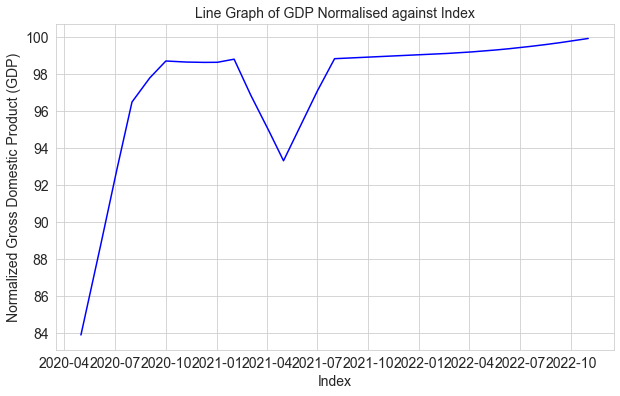

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(shaved_df["gdp_normalized"], color='b')
plt.xlabel('Index')
plt.ylabel('Normalized Gross Domestic Product (GDP)')
plt.title('Line Graph of GDP Normalised against Index')
plt.show()